In [1]:
# Importe les librairies
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan

from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics

<img src='./images/logo-oncfm.png'  width=360px/>

# Détectez des faux billets avec Python

# Sommaire

* [Importation et description des données](#1)
* [Traitement des valeurs manquantes](#2)
    * [Aperçu des données](#2-1)
    * [Mise en place et résultats du modèle](#2-2)
    * [Fiabilité du modèle](#2-3)
    * [Prédiction des valeurs manquantes](#2-4)
* [Analyse descriptive](#3)
    * [Analyse univariée](#3-1)
    * [Analyse bivariée](#3-2)

## Importation et description des données<a id='1'></a>

In [2]:
# Importe le dataset et affiche un aperçu
df_billets = pd.read_csv('./datasets/raw/billets.csv', sep=';')
df_billets.head(3)

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16


In [3]:
# Affiche le type des variables
df_billets.dtypes

is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

In [4]:
# Affiche les dimension du dataset
print(
    f'Dimensions du jeu de données :\n'
    f'- {df_billets.shape[0]} enregistrements ;\n'
    f'- {df_billets.shape[1]} variables.'
)

Dimensions du jeu de données :
- 1500 enregistrements ;
- 7 variables.


In [5]:
# Affiche le nombre de valeurs uniques
df_billets.nunique()

is_genuine        2
diagonal        159
height_left     155
height_right    170
margin_low      285
margin_up       123
length          336
dtype: int64

In [6]:
# Affiche le nombre de valeurs manquantes
df_billets.isna().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

Il manque 37 valeurs à « margin_low ». Avant de pouvoir mettre en place notre algorithme de détection, nous devons traiter ces données manquantes.

## Traitement des valeurs manquantes<a id='2'></a>

Plusieurs méthodes existent pour traiter les valeurs manquantes. Dans le cadre de ce projet, c'est la **régression linéaire multiple** qui a été retenue. Le principe consiste à modéliser une variable dépendante (ici « margin_low ») grâce à une combinaison linéaire de variables explicatives (ici « diagonal », « height_left », etc.). Ensuite, grâce aux résultats de cette régression nous allons faire une prédiction des valeurs manquantes de « margin_low ».

Pour construire notre modèle, nos données de départ ne doivent pas contenir de valeur manquantes.

In [7]:
# Crée une copie du DataFrame sans valeurs manquantes
df_billets_sans_na = df_billets.loc[
    ~df_billets.isna().any(axis='columns')].copy()

# Affiche le nombre d'enregistrements et le nombre de valeurs manquantes
print(
    f'Il y a {df_billets_sans_na.shape[0]} enregistrements et '
    f'{df_billets_sans_na.isna().sum().sum()} valeurs manquantes.'
)

Il y a 1463 enregistrements et 0 valeurs manquantes.


Nous aurons également besoin de séparer les données de la variable dépendante de celles de des variables explicatives.

In [8]:
# Sépare la variable dépendante des variables explicatives
y = df_billets_sans_na['margin_low']
X = df_billets_sans_na.drop(columns=['is_genuine', 'margin_low'])

Nous allons utiliser la librairie **scikit-learn** et ses différents modules pour réaliser toutes les opérations donc nous aurons besoin par la suite.

### Aperçu des données<a id='2-1'></a>

Première étape : on trace nos données par paires de variables grâce à la fonction ci-dessous. Cette dernière va également nous indiquer les coefficients de corrélation.

In [9]:
def pairplot_correlation(df, hue=None):
    '''
    Trace les paires de variables et affiche les coefficients de corrélation.
    Paramètres :
    - df = DataFrame source ;
    - hue = variable à différencier (couleur) sur le graphique.
    '''
    # Calcule la matrice de corrélation
    corr_matrix = df.select_dtypes(include='number').corr()

    # Définit le nombre de sous-graphiques et la taille du graphique
    fig, axs = plt.subplots(
        corr_matrix.shape[0], corr_matrix.shape[1], 
        figsize=((corr_matrix.shape[0]*1.8), (corr_matrix.shape[1]*1.4))
    )

    # Boucle sur les lignes et colonnes de la matrice de corrélation
    for i, idx in enumerate(corr_matrix.index):
        for j, col in enumerate(corr_matrix.columns):
            # Affiche le nom des variables
            if i == j:
                axs[i, j].text(x=0.5, y=0.5, s=idx, ha='center', va='center',
                               fontweight='bold')
                axs[i, j].xaxis.set_major_locator(ticker.NullLocator())
                axs[i, j].yaxis.set_major_locator(ticker.NullLocator())

            # Affiche les coefficients de corrélation
            elif i < j:
                corr_coeff = corr_matrix.loc[idx, col]
                axs[i, j].text(x=0.5, y=0.5, s=f'corr =\n{corr_coeff:.3}',
                               ha='center', va='center')
                axs[i, j].xaxis.set_major_locator(ticker.NullLocator())
                axs[i, j].yaxis.set_major_locator(ticker.NullLocator())

            # Trace les graphiques
            elif i > j:
                # Trace en fonction de la variable indiquée dans 'hue'
                if hue != None:
                    hue = hue
                    for value in df[hue].unique():
                        axs[i, j].scatter(
                            x=idx, y=col, data=df.loc[df[hue] == value], 
                            marker='.', edgecolors='k', alpha=0.65
                        )
                        axs[i, j].tick_params(axis='both', labelsize=6.5)

                # Trace sans différenciation
                elif hue == None:
                    axs[i, j].scatter(x=idx, y=col, data=df, marker='.',
                                      edgecolors='k', alpha=0.65)
                    axs[i, j].tick_params(axis='both', labelsize=6.5)

    fig.suptitle('Paires de variables et coefficients de corrélation')

    fig.tight_layout()
    # plt.subplots_adjust(right=0.95, top=0.95, wspace=0.45, hspace=0.3)

    plt.show()

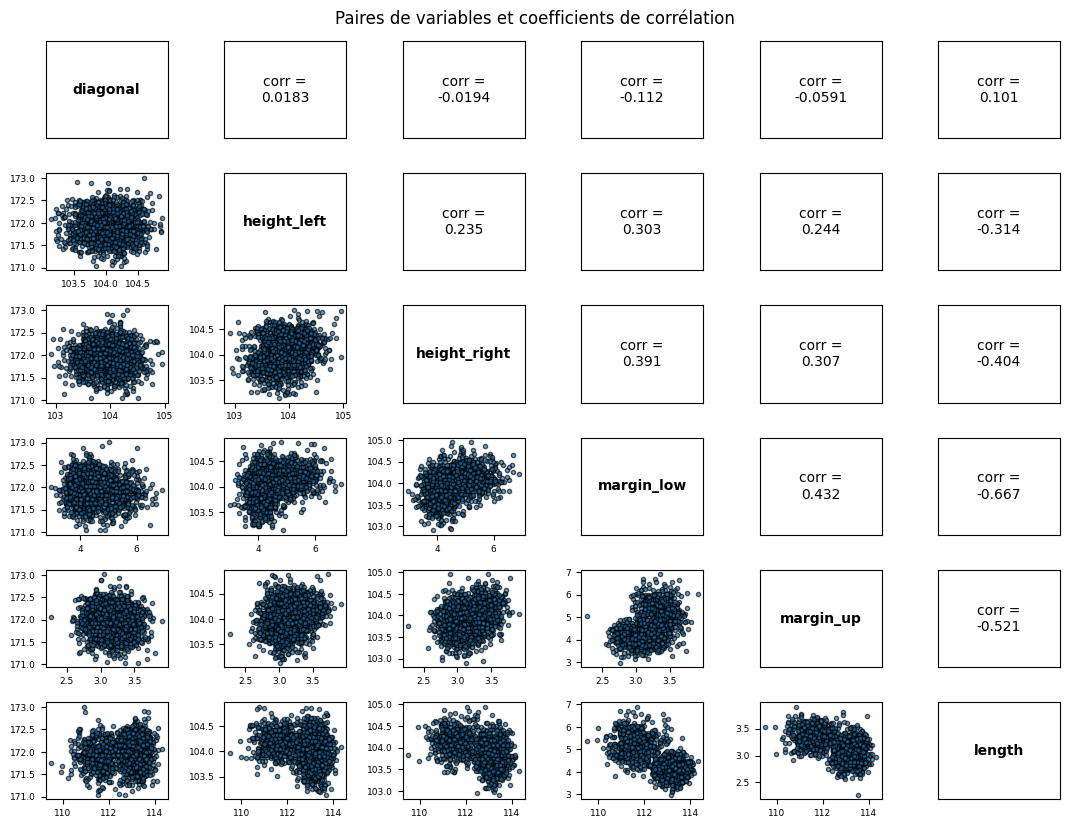

In [10]:
pairplot_correlation(df_billets_sans_na, None)

« margin_low » est dans l'ensemble plutôt bien corrélée avec les autres variables sauf avec « diagonal ». Elle est particulièrment corrélée avec « length ».

On observe également que certaines variables explicatives sont corrélées entre elles, nous allons donc vérifier la pertinence de toutes les conserver dans notre modèle. Pour cela on utilise le test du F avec les hypothèses résumées de la manière suivante :
* H<sub>0</sub> : Il n'y a pas de relation significative entre la variable explicative et la variable dépendante si p-value > 5 % ;
* H<sub>1</sub> : Il y a une relation significative entre la variable explicative et la variable dépendante si p-value < 5 %.

In [11]:
# Réalise le test du F
res = f_regression(X, y)
print(f'p-value par variable : ')
for i, column in enumerate(X.columns):
    print(f'{column:<20}{res[1][i]:>10.3g}')

del res, i, column

p-value par variable : 
diagonal               1.9e-05
height_left           2.29e-32
height_right          1.16e-54
margin_up             1.92e-67
length               8.98e-189


A chaque fois H<sub>0</sub> est rejetée, on conserve donc toutes les variables.

### Mise en place et résultats du modèle<a id='2-2'></a>

Deuxième étape : nous pouvons effectuer la régressions linéaire.

Avant cela, nous séparons nos données en deux pour avoir :
* une partie des données sur lesquelles entraîner notre modèle ;
* une partie des données sur lesquelles tester les résultats de notre modèle.

In [12]:
# Sépare les données
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Effectue la régression
reg = LinearRegression().fit(X_train, y_train)

# Affiche l'intercept et les coefficients
print(f'Coefficients : ')
print(f'''{'intercept':<20}{reg.intercept_:>6.3f}''')
for i, column in enumerate(X.columns):
    print(f'{column:<20}{reg.coef_[i]:>6.3f}')

del i, column

Coefficients : 
intercept           19.510
diagonal            -0.072
height_left          0.187
height_right         0.234
margin_up            0.266
length              -0.420


Nous allons maintenant évaluer notre modèle grâce à différents indicateurs. Au préalable sur devons appliquer le modèle à nos données « test ».

In [13]:
# Effectue la prédiction sur les données test
y_pred = reg.predict(X_test)

In [14]:
# Calcule et affiche les différents indicateurs
model_metrics = ['r2', 'mae', 'mse', 'rmse']

r2 = reg.score(X_train, y_train)
mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = metrics.mean_squared_error(y_test, y_pred, squared=False)

print(f'Indicateurs : ')
for i, metric in enumerate(model_metrics):
    print(f'{model_metrics[i].upper():<10}{eval(metric):>5.3f}')

del model_metrics, mae, mse, rmse, i, metric

Indicateurs : 
R2        0.481
MAE       0.369
MSE       0.233
RMSE      0.483


Le coefficient R² indique que le modèle explique moyennement la variance. A l'inverse, le carré moyen des erreurs (MSE) est plutôt proche de 0 ce qui est une bonne chose car c'est la valeur que l'on cherche à minimiser dans le cadre d'une régression.

Pour terminer notre analyse nous allons calculer la valeur de R²<sub>ajusté</sub> qui est plus adapté dans le cadre d'une régression multiple. Il se calule de la manière suivante :

$R_{ajusté}^2 = 1-[\frac{(1-R^2)\times(n-1)}{n-k-1}]$<br>
Avec :
* $n$ : le nombre d'observations ;
* $k$ : le nombre de variables explicatives.

In [15]:
# Calcule R² ajusté
n = len(y_test)
k = len(X_test.columns)
ajusted_r2 = 1 - ((1-r2)*(n-1)/(n-k-1))

# Affiche la valeur de R² ajusté
print(f'R2 ajusté = {ajusted_r2:.3f}')

del n, k, r2, ajusted_r2

R2 ajusté = 0.476


La valeur de R²<sub>ajusté</sub> est légèrement inférieure à la valeur de R².

### Fiabilité du modèle<a id='2-3'></a>

Afin de nous assurer que notre modèle est fiables, il est important de vérifier que plusieurs hypothèses sont satisfaites. Dans un premier temps, on calcul les résidus de notre modèle.

In [16]:
# Calcule les résidus
residuals = y_test - y_pred

#### Hypothèse 1 : linéarité du modèle

La relation entre les variables explicatives et la variable cible doit être linéaire. Pour vérifier cela, on trace les résidus en fonction des valeurs prédites et on vérifie si on observe une relation linéaire.

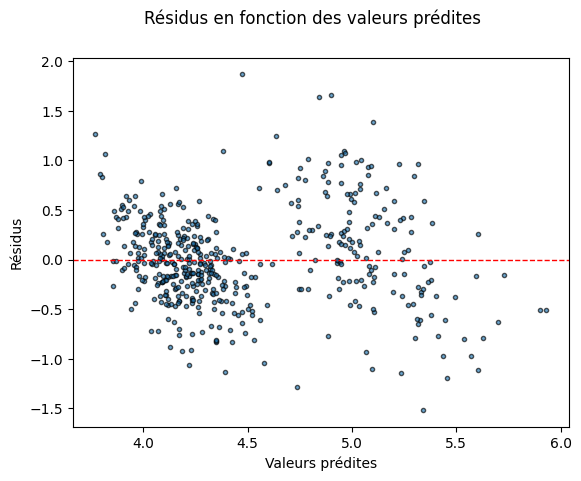

In [17]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=y_pred, y=residuals, marker='.', edgecolors='k',
           alpha=0.65)
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Valeurs prédites')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction des valeurs prédites')

plt.show()

del fig, ax

Dans notre cas, il ne semble pas y avoir de relation linéaire.

#### Hypothèse 2 : indépendance des résidus

Les résidus ne doivent pas être liés c’est-à-dire que la valeur d’un résidu ne doit pas nous permettre de connaître celui d’un autre. Même si cette hypothèse concerne plutôt les séries temporelles, on peut tout de même tracer les valeurs des résidus en fonction des observations.

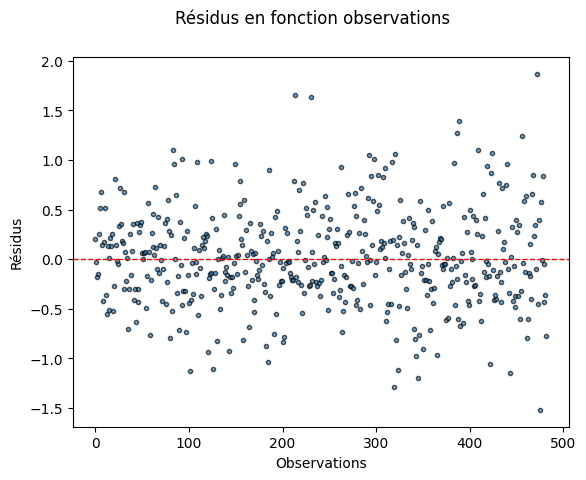

In [18]:
# Trace le graphique
fig, ax = plt.subplots()

ax.scatter(x=range(len(residuals)), y=residuals, marker='.',
           edgecolors='k', alpha=0.65)
ax.axhline(y=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Observations')
ax.set_ylabel('Résidus')
fig.suptitle('Résidus en fonction observations')

plt.show()

del fig, ax

Les résidus semblent répartis de manière aléatoire autour de 0. Pour confimer notre observation, on réalise un test de Durbin-Watson. Cette statistique a une valeur comprise entre 0 et 4. Si elle est proche de zéro, l'autocorrélation est positive, les valeurs situées autour de 2 montrent une absence d’autocorrélation et si l’on s’approche de 4, il existe une autocorrélation négative.

In [19]:
# Calcule et affiche le résultat du test de Durbin-Watson
res = durbin_watson(residuals)
print(f'Durbin-Watson = {res:.3f}')

del res

Durbin-Watson = 2.070


Ici la valeur est proche de 2 donc il y a indépendance des résidus.

#### Hypothèse 3 : homoscédasticité

L'homoscédasticité significie que la variance des résidus est constante. Nous avons constaté précédemment que les résidus sont dispersés de manière relativement uniforme autour de 0 donc on considère que l'homoscédasticité est probablement satisfaite.

L'homoscédasticité significie que la variance des résidus est constante. Nous avons constaté précédemment que les résidus sont dispersés de manière relativement uniforme autour de 0 donc l'homoscédasticité est probablement satisfaite. Néanmoins, nous allons réaliser le test statistique de Breush-Pagan dont les hypothèses sont les suivantes :
* H<sub>0</sub> : L’homoscédasticité est présente si p-value > 5 % ;
* H<sub>1</sub> : L’homoscédasticité n’est pas présente si p-value < 5 %.

In [20]:
# Réalise le test de Breush-Pagan
res = het_breuschpagan(residuals, X_test.assign(constant=1))

print(f'Résultat du test de Breush-Pagan :\n>> p-value = {res[1]:.2e}')
if res[1] > 0.05:
    print(f'   H0 est retenue, homoscédasticité est présente.')
elif res[1] < 0.05:
    print(f'   H1 est retenue, homoscédasticité n\'est pas présente.')

del res

Résultat du test de Breush-Pagan :
>> p-value = 1.21e-05
   H1 est retenue, homoscédasticité n'est pas présente.


#### Hypothèse 4 : normalité des résidus

Les valeurs des résidus doivent suivre une loi normale. On trace la distribution des résidus.

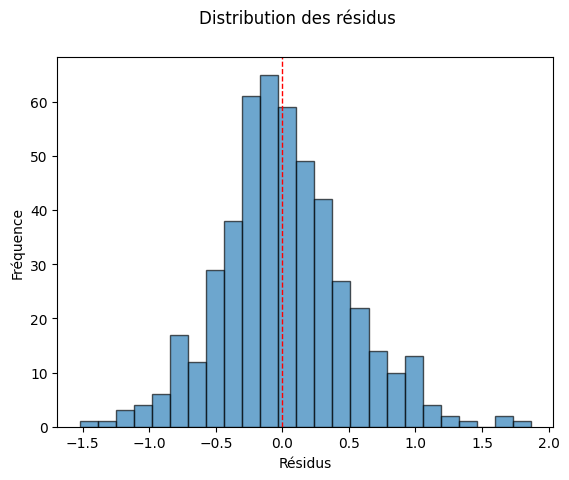

In [21]:
# Trace le graphique
fig, ax = plt.subplots()

ax.hist(x=residuals, bins=25, edgecolor='k', alpha=0.65)
ax.axvline(x=0, color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Résidus')
ax.set_ylabel('Fréquence')
fig.suptitle('Distribution des résidus')

plt.show()

del fig, ax

On observe un décalage sur la gauche mais, à priori, la distribution semble correcte. Nous allons réaliser un test de Shapiro-Wilk ayant les hypothèses suivantes :
* H<sub>0</sub> : La normalité est vérifiée si p-value > 5 % ;
* H<sub>1</sub> : La normalité n'est pas vérifiée si p-value < 5 %.

In [22]:
# Réalise le test de Shapiro-Wilk
from scipy import stats
res = stats.shapiro(residuals)

print(f'Résultat du test de Shapiro-Wilk :\n>> p-value = {res.pvalue:.2e}')
if res.pvalue > 0.05:
    print(f'   H0 est retenue, la normalité est vérifiée.')
elif res.pvalue < 0.05:
    print(f'   H1 est retenue, la normalité n\'est pas vérifiée.')

del res

Résultat du test de Shapiro-Wilk :
>> p-value = 1.65e-03
   H1 est retenue, la normalité n'est pas vérifiée.


#### Hypothèse 5 : pas de colinéarité

Les variables explicatives ne doivent pas être fortement très corrélées entre elles. Nous avions cependant observé quelques coefficients de corrélation assez élevés. Afin de déterminer si cette hypothèse est validée, nous allons calculer le « VIF » (facteur d'inflation de variance) pour chaque variable explicative :
* si VIF = 1 : pas de corrélation entre les variables explicatives ;
* si 1 < VIF ≤ 5 : il y a une corrélation modérée mais ne nécessite pas forcément une attention particulière ;
* si VIF > 5 : il y a une corrélation importante qui peut nuire au résultat de la régression.

Nous allons donc calculer le VIF à partir de la formule suivant :

$VIF_i = \frac{1}{1-R_i^2}$<br>
Avec :
* $R_i^2$ : valeur de R² de la regression pour chaque variable explicative considérée comme dépendante.

In [23]:
# Calcule le VIF pour chaque variable explicative considérée dépendante
print(f'''{'Variable':<15}VIF''')
for column in X_train.columns:
    y_vif = X_train[column]
    X_vif = X_train.drop(columns=column)
    reg_vif = LinearRegression().fit(X_vif, y_vif)
    r2_vif = reg_vif.score(X_vif, y_vif)
    vif = 1 / (1 - r2_vif)
    print(f'{column:<15}{vif:.3f}')

del column, y_vif, X_vif, reg_vif, r2_vif, vif

Variable       VIF
diagonal       1.006
height_left    1.167
height_right   1.206
margin_up      1.451
length         1.597


Toutes les valeurs sont proches de 1, il n'y a pas de problème de colinéarité dans notre exemple.

### Prédiction des valeurs manquantes<a id='2-4'></a>

In [24]:
# Copie les enregistrements contenant les valeurs manquantes
df_billets_na = df_billets.loc[df_billets.isna().any(axis='columns')].copy()

# Préidt les valeurs manquantes grâce au modèle
df_billets_na['margin_low'] = reg.predict(
    df_billets_na.drop(columns=['is_genuine', 'margin_low']))

# Concatène les enregistrements avec et sans valeurs manquantes
df_billets = pd.concat([df_billets_sans_na, df_billets_na]).sort_index()

del df_billets_sans_na, df_billets_na, X, y, X_train, y_train, X_test, y_test, y_pred, reg, residuals

## Analyse descriptive<a id='3'></a>

### Analyse univariée<a id='3-1'></a>

In [25]:
df_billets.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [26]:
df_billets.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1500 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 83.5 KB


In [27]:
df_billets.describe(include='all')

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
count,1500,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.00000
unique,2,NaN,NaN,NaN,NaN,NaN,NaN
top,True,NaN,NaN,NaN,NaN,NaN,NaN
freq,1000,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,171.958440,104.029533,103.920307,4.483320,3.151473,112.67850
std,NaN,0.305195,0.299462,0.325627,0.659744,0.231813,0.87273
min,NaN,171.040000,103.140000,102.820000,2.980000,2.270000,109.49000
25%,NaN,171.750000,103.820000,103.710000,4.020000,2.990000,112.03000
50%,NaN,171.960000,104.040000,103.920000,4.310000,3.140000,112.96000
75%,NaN,172.170000,104.230000,104.150000,4.870000,3.310000,113.34000


In [28]:
# Affiche les quantités de vrais/faux billets
print(
    f'Le jeu de données comprend :\n'
    f'''- {sum(df_billets['is_genuine'] == True)} billets authentiques ;\n'''
    f'''- {sum(df_billets['is_genuine'] == False)} faux billets.'''
)

Le jeu de données comprend :
- 1000 billets authentiques ;
- 500 faux billets.


In [29]:
df_billets.groupby('is_genuine').agg('mean')

,diagonal,height_left,height_right,margin_low,margin_up,length
is_genuine,,,,,,
False,171.90116,104.19034,104.14362,5.214114,3.35016,111.63064
True,171.98708,103.94913,103.80865,4.117923,3.05213,113.20243
